## 用户画像和商品画像

画像旨在通过从海量用户数据和商品数据中炼银挖金，尽可能全面细致地抽出一个用户或商品的信息全貌，从而帮助解决如何把数据转化为商业价值的问题。

#### 画像建模：

画像建模，简言之，就是给用户/商品打标签，那么具体打些什么样的标签：
- 用户画像主要展现用户的兴趣标签（长期兴趣、短期兴趣、实时兴趣）。兴趣主要包括性别、年龄、品牌偏好、品类偏好、购买力等级、尺码颜色偏好、促销敏感度、资产状况、家庭情况等。
- 商品画像主要包括商品的产品词、修饰词、属性词、品牌词、品类词、价格档次、适用人群性别、适用人群年龄等标签


#### 商品画像建模

定义商品画像标签：
- 产品词、修饰词、属性词等基于商品提取的关键词
- 品牌词、品类词、价格档次等基于商品属性
- 适用人群性别、年龄等基于商品购买历史、商品特性

建立商品画像表: 商品画像不同的标签往往根据特性会分为多个表进行存储

商品的品牌词(品牌1、2、3)、品类词(类别1、2、3)、价格档次(高:1、中:2、低:3)、适用人群性别(男:1、女:2)、年龄(少年:1、青年:2、中年:3等)等标签，每个商品通常只对应某一个具体的值，因此这样的标签可以设计在一张表中存储。如
```sql
CREATE TABLE IF NOT EXISTS item_features_table(
sku_id INT,
brand_id INT,
cate_id INT,
price_level INT, 
gender INT, 
age_level INT
)
```

而商品的产品词、修饰词、属性词，由于每个商品都会有多个词与之对应，且取值范围无法固定，因此每个商品的这些词会在多行中进行存储。而其实此前我们对每件商品提取出的关键词，就包括刚刚提到的产品词、修饰词、属性词。如

```sql
CREATE TABLE IF NOT EXISTS item_keywords_table(
sku_id INT,
cate STRING,
brand STRING,
keyword STRING,
weights DOUBLE
)
```

#### 用户画像建模

画像类型：
- 长期兴趣画像：根据用户所有的历史行为记录来刻画
- 短期兴趣画像：根据用户近期的历史行为记录来刻画
- 实时兴趣画像：根据用户实时的历史行为记录来刻画

长期兴趣和短期兴趣主要用来进行离线推荐，可以使用hive来进行维护实现离线推荐(离线召回、模型训练等任务)，而实时兴趣画像目的是为了进行实时推荐(在线召回、在线特征更新、在线排序)，因此会使用redis、hbase这样的数据库来存储

标签：
- 性别、年龄、教育状况等基于人口统计学的标签
- 品牌偏好、品类偏好、尺码颜色偏好等基于用户行为统计的标签
- 购买力等级、活跃度等基于规则的标签

同样的对于性别、年龄、教育状况、是否有孩子、孩子年龄、购买力等级、活跃度等可以设计到一张表中：
```sql
CREATE TABLE IF NOT EXISTS user_features_table(
user_id INT,
gender INT,
age_level INT,
education INT,
height DOUBLE,
has_child INT,
child_age_level INT,
comsume_level INT,
active_level INT
)
```

对于用户品牌偏好、品类偏好、尺码偏好、颜色偏好等，如果数据量中等可以全部存在一张表中，如果用户量大，那么应该拆分表来存储。如
```sql
CREATE TABLE IF NOT EXISTS user_brand_table(
user_id INT,
brand_id INT,
weights DOUBLE
)

CREATE TABLE IF NOT EXISTS user_cate_table(
user_id INT,
cate_id INT,
weights DOUBLE
)
......
```
这样做的话可以提高查询速度，解耦存储逻辑等。当然也会带来的一些问题，如表连接、聚合操作较多等等。

**可见画像中大部分数据都设置为了数值**，这里主要原因有两个：1. 节约存储空间 2. 便于进行特征处理


#### 部分标签值计算说明

物品的价格等级：item_features_table中`price_level`的计算：
- 首先划分等级，如分为两级、三级还是五级
- 然后最简单的方式就是根据直接使用价格排序方式，直接划分出三个或五个等不同的等级

用户的消费等级：comsume_level
- 同样首先划分等级，通常和商品价格等级相同
- 然后根据用户购买历史来进行加权，得出用户总的消费等级情况，当然如果想要刻画更精细的画像，可以考虑把用户每一个大类的消费等级计算出来进行保存

用户活跃度：active_level
- 同样首先划分等级，如不活跃、活跃、非常活跃
- 指定规则，比如：当发现用户近七天天登录，并发生多次点击浏览行为，可记录为非常活跃；当发现用户最近7天只有三天有类似行为，则为活跃；否则为不活跃。从用户历史点击流日志数据中进行分析提取

用户对品类、品牌等的偏好权重的计算可参考此前项目1中的方式进行计算

其他还有众多的标签，尤其是用户的标签，往往都需要指定一套合适规则，然后从用户历史行为记录中查询分析出来，最终形成完成的用户画像。

#### 一般来讲，画像颗粒度越细致，越能得出更加个性化的推荐结果，但相应地的难度也会随之增大

如商品画像中服装类产品，对商品进行画像的时候，主要从商品的自然属性和销售状况出发细化特征：
- 商品的颜色
- 面料
- 尺码
- 价位段
- 品类
- 品类结构比
- 波段规划
- 季节性特征
- 气候性特征
- 销售渠道
- 销售区域
- 竞争对手表现
- 市场容量
- 市场占比
- 产品生命周期趋势
- 供应商支持情况
- 整体销售趋势
等等

如用户画像以下六大维度特征：
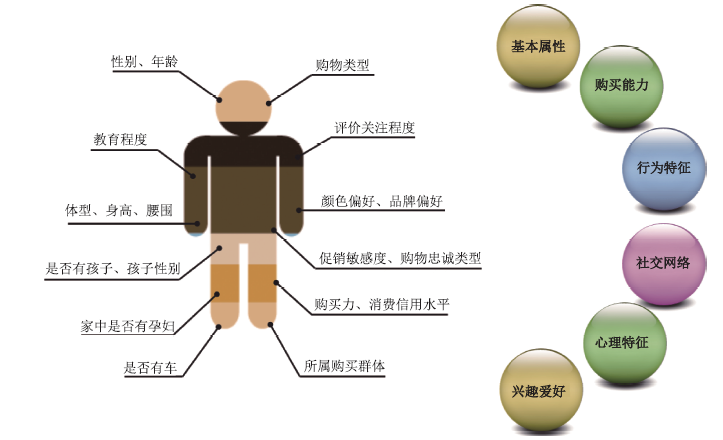

到这里有没有发现，对产品越熟悉，那么实现的推荐也将越个性化。

调侃：不能当产品经理的程序员不是一个好的程序员